In [881]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import talib as ta
from talib import abstract
import yfinance as yfin
import openpyxl

In [882]:
df = yfin.download('^TWII', start = '2024-7-1', end = '2024-7-31', interval = '5m')
df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Datetime,,,,,,
2024-07-04 09:00:00+08:00,23360.880859,23463.580078,23360.880859,23459.029297,23459.029297,0
2024-07-04 09:05:00+08:00,23458.949219,23458.949219,23424.289062,23434.660156,23434.660156,0
2024-07-04 09:10:00+08:00,23429.109375,23486.689453,23418.449219,23427.439453,23427.439453,0
2024-07-04 09:15:00+08:00,23426.990234,23432.800781,23407.830078,23417.269531,23417.269531,0
2024-07-04 09:20:00+08:00,23418.080078,23427.189453,23407.640625,23415.039062,23415.039062,0
...,...,...,...,...,...,...
2024-07-30 13:05:00+08:00,22253.589844,22273.240234,22235.390625,22269.460938,22269.460938,0
2024-07-30 13:10:00+08:00,22246.929688,22262.710938,22200.220703,22206.650391,22206.650391,0
2024-07-30 13:15:00+08:00,22195.880859,22225.839844,22185.640625,22225.839844,22225.839844,0


In [883]:
# 建立UT Bot Alert
# 参數
a = 2  # Key Value
c = 6  # ATR Period

df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=c)
df['nLoss'] = a * df['ATR']
df['xATRTrailingStop'] = 0
src = df['close']

# xATRTrailingStop
for i in range(1, len(df)):
    if src.iloc[i] > df.iloc[i - 1]['xATRTrailingStop'] and src.iloc[i - 1] > df.iloc[i - 1]['xATRTrailingStop']:
        df['xATRTrailingStop'][i] = max(df.iloc[i - 1]['xATRTrailingStop'], src.iloc[i] - df.iloc[i]['nLoss'])
    elif src.iloc[i] < df.iloc[i - 1]['xATRTrailingStop'] and src.iloc[i - 1] < df.iloc[i - 1]['xATRTrailingStop']:
        df['xATRTrailingStop'][i] = min(df.iloc[i - 1]['xATRTrailingStop'], src.iloc[i] + df.iloc[i]['nLoss'])
    elif src.iloc[i] > df.iloc[i - 1]['xATRTrailingStop']:
        df['xATRTrailingStop'][i] = src.iloc[i] - df.iloc[i]['nLoss']
    else:
        df['xATRTrailingStop'][i] = src.iloc[i] + df.iloc[i]['nLoss']

# EMA
df['EMA'] = ta.EMA(df['close'], timeperiod=14)

# buy/sell
df['buy'] = (df['close'] > df['xATRTrailingStop']) & (df['EMA'] > df['xATRTrailingStop'])
df['sell'] = (df['close'] < df['xATRTrailingStop']) & (df['EMA'] < df['xATRTrailingStop'])

# barbuy/barsell
df['barbuy'] = df['close'] > df['xATRTrailingStop']
df['barsell'] = df['close'] < df['xATRTrailingStop']

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_14705/3526702729.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['xATRTrailingStop'][i] = max(df.iloc[i - 1]['xATRTrailingStop'], src.iloc[i] - df.iloc[i]['nLoss'])
/var/fold

In [884]:
# 建立STC indicator
# 参数
lengthInput = 80
smoothingFactor = 0.5
fastLength = 27
slowLength = 50
tdf = pd.DataFrame()

def calculate_macd(close, fastLength, slowLength):
    ema_fast = ta.EMA(close, timeperiod=fastLength)
    ema_slow = ta.EMA(close, timeperiod=slowLength)
    macd = ema_fast - ema_slow

    return macd

def calculate_stc(close, lengthInput, fastLength, slowLength, smoothingFactor):
    macd = calculate_macd(close, fastLength, slowLength)
    macd = pd.Series(macd)

    # max/min MACD
    lowest_macd = macd.rolling(window=lengthInput, min_periods=1).min()
    highest_macd = macd.rolling(window=lengthInput, min_periods=1).max() - lowest_macd
    normalized_macd = 100 * (macd - lowest_macd) / highest_macd.replace(0, np.nan)
    
    # smoothing
    smoothed_macd = normalized_macd.ewm(alpha=smoothingFactor, adjust=False).mean()
    lowest_smoothed_macd = smoothed_macd.rolling(window=lengthInput, min_periods=1).min()
    highest_smoothed_macd = smoothed_macd.rolling(window=lengthInput, min_periods=1).max() - lowest_smoothed_macd
    smoothed_normalized_macd = 100 * (smoothed_macd - lowest_smoothed_macd) / highest_smoothed_macd.replace(0, np.nan)
    
    stc_value = smoothed_normalized_macd.ewm(alpha=smoothingFactor, adjust=False).mean()
    return stc_value - 50, macd

def calculate_macd_histogram(macd, high, low, slowLength):
    ema_high_low = ta.EMA(high - low, timeperiod=slowLength)
    macd_value = macd / ema_high_low * 100
    macd_value = (macd_value - ta.EMA(macd_value, timeperiod=9)) / 2
    return macd_value

# STC/MACD
df['STCValue'], df['MACDValue'] = calculate_stc(df['close'], lengthInput, fastLength, slowLength, smoothingFactor)

# MACD's Histogram
df['MACDValue'] = calculate_macd_histogram(df['MACDValue'], df['high'], df['low'], slowLength)

In [885]:
# 建立HULL Suit
# 定义 HULL MA 函数
def wma(series, length):
    weights = np.arange(1, length + 1)
    return series.rolling(window=length).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

def hma(series, length):
    half_length = int(length / 2)
    sqrt_length = int(np.sqrt(length))
    return wma(2 * wma(series, half_length) - wma(series, length), sqrt_length)

def ehma(series, length):
    half_length = int(length / 2)
    sqrt_length = int(np.sqrt(length))
    return ta.trend.EMAIndicator(series, window=half_length).ema_indicator() * 2 - ta.trend.EMAIndicator(series, window=length).ema_indicator()

def thma(series, length):
    one_third_length = int(length / 3)
    return wma(wma(series, one_third_length) * 3 - wma(series, int(length / 2)) - wma(series, length), length)

def calculate_hull(series, length, method="Hma"):
    if method == "Hma":
        return hma(series, length)
    elif method == "Ehma":
        return ehma(series, length)
    elif method == "Thma":
        return thma(series, length)
    else:
        raise ValueError("Invalid method. Choose from 'Hma', 'Ehma', 'Thma'.")

# 计算 HULL MA
length = 55
length_mult = 1.0
method = "Hma"
df['HULL'] = calculate_hull(df['close'], int(length * length_mult), method)
df['HULL'] = df['HULL'].fillna(method='bfill')  # 处理 NaN

/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_14705/2517865295.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['HULL'] = df['HULL'].fillna(method='bfill')  # 处理 NaN


以下未完成

In [886]:
#strategy execute long
'''
UT發出買入訊號、STC < 25並顯示向上、價格在HULL之上
滿足以上三者為關鍵Ｋ線，其收盤價為多單進場位置
止損為關鍵Ｋ線低點
止盈以固定盈虧比和右側止盈結合．1:3和價格跌破HULL線
'''
df['BuySignal'] = (df['buy']) & (df['STCValue'] < 25) & (df['STCValue'].diff() > 0) & (df['close'] > df['HULL'])

df['EntryPrice'] = np.nan
df['StopLoss'] = np.nan
df['ExitPrice'] = np.nan

for i in range(len(df)):
    if df['BuySignal'].iloc[i]:
        df['EntryPrice'][i] = df['close'].iloc[i]
        df['StopLoss'] = df['low'].iloc[i]

df['TakeProfit'] = df['EntryPrice'] + 3 * (df['EntryPrice'] - df['StopLoss'])

# 初始化 ExitPrice 列

for i in range(1, len(df)):
    if not np.isnan(df.iloc[i]['EntryPrice']):
        entry_price = df.iloc[i]['EntryPrice']
        stop_loss = df.iloc[i]['StopLoss']
        take_profit = df.iloc[i]['TakeProfit']

        for j in range(i + 1, len(df)):
            # 如果价格触及固定盈亏比止盈点
            if df.iloc[j]['high'] >= take_profit:
                df.iloc[j, df.columns.get_loc('ExitPrice')] = take_profit
                break
            # 如果价格跌破HULL线
            elif df.iloc[j]['close'] < df.iloc[j]['HULL']:
                df.iloc[j, df.columns.get_loc('ExitPrice')] = df.iloc[j]['close']
                break


/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_14705/1529889106.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['EntryPrice'][i] = df['close'].iloc[i]
/var/folders/0j/sdf7gd116kd5lv12gdjc81900000gn/T/ipykernel_14705/15298

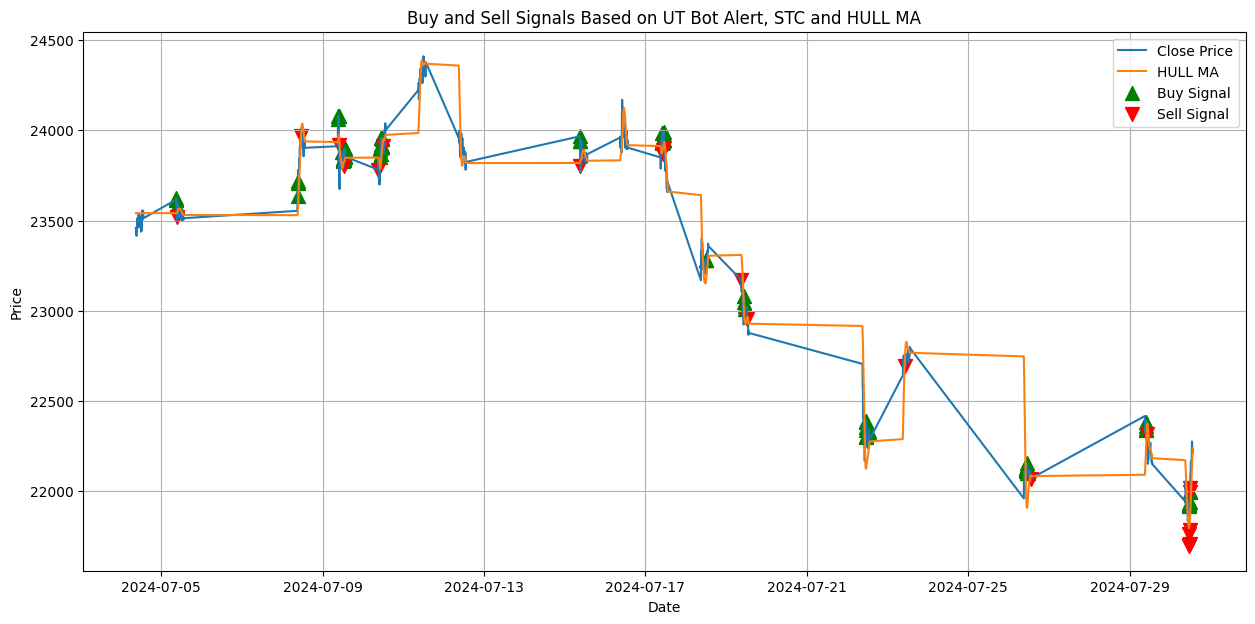

In [888]:
# 绘图
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close'], label='Close Price')
plt.plot(df.index, df['HULL'], label='HULL MA')

# 绘制买入和卖出信号
buy_signals = df[df['EntryPrice'].notnull()]
sell_signals = df[df['ExitPrice'].notnull()]

plt.scatter(buy_signals.index, buy_signals['EntryPrice'], marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['ExitPrice'], marker='v', color='r', label='Sell Signal', s=100)

plt.legend()
plt.title('Buy and Sell Signals Based on UT Bot Alert, STC and HULL MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()

In [887]:
df.index = df.index.tz_localize(None)
df.to_excel('data.xlsx')